In [2]:
import pefile
import os
import re
import magic
import pandas as pd
import numpy as np

In [3]:
#CAMBIAR ESTE PATH DEPENDIENDO DE DONDE SE GUARDEN LOS EJECUTABLES DEL MALWARE
path = "MALWR"

## Utilizando las funciones del laboratorio pasado

In [4]:
class PEFile:
    #Esta calse servira para guardar informacion interesante de los archivos
    
    def __init__(self, filename):

        self.pe = pefile.PE(filename, fast_load=True)
        
        self.filename = filename      
        self.DebugSize = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[6].Size
        self.DebugRVA = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[6].VirtualAddress
        self.ImageVersion = self.pe.OPTIONAL_HEADER.MajorImageVersion
        self.OSVersion = self.pe.OPTIONAL_HEADER.MajorOperatingSystemVersion
        self.ExportRVA = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[0].VirtualAddress
        self.ExportSize = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[0].Size
        self.IATRVA = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[12].VirtualAddress
        self.ResSize = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[2].Size
        self.LinkerVersion = self.pe.OPTIONAL_HEADER.MajorLinkerVersion
        self.NumberOfSections = self.pe.FILE_HEADER.NumberOfSections
        self.StackReserveSize = self.pe.OPTIONAL_HEADER.SizeOfStackReserve
        self.Dll = self.pe.OPTIONAL_HEADER.DllCharacteristics
        self.AddressOfEntryPoint = self.pe.OPTIONAL_HEADER.AddressOfEntryPoint
        self.ImageBase = self.pe.OPTIONAL_HEADER.ImageBase
        self.SHA256 = ""
        
        # If the PE file was loaded using the fast_load=True argument, we will need to parse the data directories:
        self.pe.parse_data_directories()
        imported_dll = {}
        number_dll = 0
        try:
            for entry in self.pe.DIRECTORY_ENTRY_IMPORT:
                if entry is not None:
                    number_dll += 1
                    for imp in entry.imports:
                        if imp.name is not None:
                            imported_dll[entry.dll.decode()] = imp.name.decode()
        except:
            pass
                        
        self.ImportedDLL = imported_dll
        self.NumberOfImportDLL = number_dll
        
        section_names = {}
        number_sections = 0
        try:
            for section in self.pe.sections:
                number_sections += 1
                section_names[section.Name.decode()] = section.SizeOfRawData
                self.SHA256 = section.get_hash_sha256()
            self.SectionNames = section_names
            self.NumberOfSections = number_sections
        except:
            pass
            
        number_import_functions = 0
        import_function = []
        
        try:
            if self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[pefile.DIRECTORY_ENTRY['IMAGE_DIRECTORY_ENTRY_IMPORT']].VirtualAddress != 0:
                self.pe.parse_data_directories(directories=[pefile.DIRECTORY_ENTRY['IMAGE_DIRECTORY_ENTRY_IMPORT']])
                for entry in self.pe.DIRECTORY_ENTRY_IMPORT:
                    for imp in entry.imports:
                        if imp.name:
                            number_import_functions += 1
                            import_function.append(imp.name.decode())
        except:
            pass
            
        self.NumberOfImportFunctions = number_import_functions
        self.ImportedFunctions = import_function
        
    def Construct(self):
        sample = {}

        for attr, k in self.__dict__.items():
            if(attr != "pe"):
                sample[attr] = k
        return sample

In [5]:
def pe2vec(directory):
    dataset = {}
    print("")
    print("[*] Extracting the PE file data: ")
    print("")
    for subdir, dirs, files in os.walk(directory):
        for f in files:
            file_path = os.path.join(subdir, f)
            
            if re.match('^PE.*', magic.from_file(file_path)):
                try:
                    pe = PEFile(file_path)
                    dataset[str(f)] = pe.Construct()
                except Exception as e:
                    raise
            else:
                os.remove(file_path)
    return dataset

In [6]:
dsmalware = {}
dsmalware = pe2vec(path)


[*] Extracting the PE file data: 



In [7]:
def vec2csv(dataset, output_file):
    df = pd.DataFrame(dataset)
    test_data = df.transpose() 
    test_data.to_csv(output_file,sep=',', encoding='utf-8')
    print("")
    print("[+] Saving file to: " + output_file)
    print("")

In [8]:
output= "./malware.csv"
vec2csv(dsmalware, output)


[+] Saving file to: ./malware.csv



In [9]:
df = pd.read_csv("./malware.csv")

In [10]:
df.head()

,Unnamed: 0,filename,DebugSize,DebugRVA,ImageVersion,OSVersion,ExportRVA,ExportSize,IATRVA,ResSize,...,StackReserveSize,Dll,AddressOfEntryPoint,ImageBase,SHA256,ImportedDLL,NumberOfImportDLL,SectionNames,NumberOfImportFunctions,ImportedFunctions
0,sample_vg655_25th.exe,MALWR/sample_vg655_25th.exe,0,0,0,4,0,0,32768,3448736,...,1048576,0,30650,4194304,418c45aa8ad5b74ea7a820a4cf19b2fbc688502752d600...,"{'KERNEL32.dll': 'FindResourceA', 'USER32.dll'...",4,"{'.text\x00\x00\x00': 28672, '.rdata\x00\x00':...",114,"['GetFileAttributesW', 'GetFileSizeEx', 'Creat..."
1,sample_qwrty_dk2,MALWR/sample_qwrty_dk2,0,0,0,4,0,0,0,128,...,1048576,0,3422617582,4194304,11d286fa2bbee33cd3725c19dd1f84d976193c533cd10b...,"{'KERNEL32.DLL': 'GetModuleHandleA', 'MSVCRT.d...",5,"{'.text\x00\x00\x00': 4096, '.rdata\x00\x00': ...",62,"['CloseHandle', 'WaitForSingleObject', 'Create..."


1. Utilice la herramienta pefile para examinar el PE header y obtenga las DLL y las APIs que los 
ejecutables  llaman.  ¿Qué  diferencias  observa  entre  los  ejemplos?  ¿Existe  algún  indicio 
sospechoso en la cantidad de DLLs y las APIs llamadas? 

In [11]:
df[["NumberOfImportDLL","NumberOfImportFunctions"]]

,NumberOfImportDLL,NumberOfImportFunctions
0,4,114
1,5,62


Si existe una diferencia entre ellos, el primer archivo llama a un DLL menos pero tiene una mayor cantidad de llamadas a APIs, por otro lado el segundo archivo tiene mas DLLs pero una cantidad mucho menor de llamadas a APIs esto puede llegar a ser sospechoso ya que a tener una mayor cantidad de DLLs se esperaria tambien una mayor cantidad de llamadas a APIs

2. Obtenga la información de las secciones del PE Header. ¿Qué significa que algunas secciones 
tengan como parte de su nombre “upx”? Realice el procedimiento de desempaquetado para 
obtener las llamadas completas de las APIs. 

In [12]:
df[["SectionNames"]]

,SectionNames
0,"{'.text\x00\x00\x00': 28672, '.rdata\x00\x00':..."
1,"{'.text\x00\x00\x00': 4096, '.rdata\x00\x00': ..."


El UPX se refiere a un metodo de empaquetado que se utiliza comunmente en malwares para esconder infomracion sobre el ejecutable. Esto indica que la seccion sigue empaquetada

In [13]:
dsmalware = {}
dsmalware = pe2vec(path)


[*] Extracting the PE file data: 



In [14]:
output= "./unpackedmalware.csv"
vec2csv(dsmalware, output)


[+] Saving file to: ./unpackedmalware.csv



In [15]:
df = pd.read_csv("./unpackedmalware.csv")

In [16]:
df[["NumberOfImportDLL","NumberOfImportFunctions"]]

,NumberOfImportDLL,NumberOfImportFunctions
0,4,114
1,5,62


se puede observar que el archivo tenia llamadas empaquetadas

3. Según el paper “Towards Understanding Malware Behaviour by the Extraction of API Calls”, 
¿en que categoría sospechosas pueden clasificarse estos ejemplos en base a algunas de las 
llamadas a las APIs que realizan? Muestre una tabla con las APIs sospechosas y la categoría de 
malware que el paper propone. 

In [17]:
function_names = df[["ImportedFunctions"]]
print("Llamadas primer archivo")
for function in function_names["ImportedFunctions"]:
    removed_chars =function.replace("'", '')
    removed_chars2 = removed_chars.replace('[','')
    removed_chars3 = removed_chars.replace(']','')
    removed_chars4 = removed_chars.replace(' ' ,'')
    function_list = removed_chars4.split(',')
    print(function_list)
    print("------------------------------------------------------------------------------------")

Llamadas primer archivo
['[GetFileAttributesW', 'GetFileSizeEx', 'CreateFileA', 'InitializeCriticalSection', 'DeleteCriticalSection', 'ReadFile', 'GetFileSize', 'WriteFile', 'LeaveCriticalSection', 'EnterCriticalSection', 'SetFileAttributesW', 'SetCurrentDirectoryW', 'CreateDirectoryW', 'GetTempPathW', 'GetWindowsDirectoryW', 'GetFileAttributesA', 'SizeofResource', 'LockResource', 'LoadResource', 'MultiByteToWideChar', 'Sleep', 'OpenMutexA', 'GetFullPathNameA', 'CopyFileA', 'GetModuleFileNameA', 'VirtualAlloc', 'VirtualFree', 'FreeLibrary', 'HeapAlloc', 'GetProcessHeap', 'GetModuleHandleA', 'SetLastError', 'VirtualProtect', 'IsBadReadPtr', 'HeapFree', 'SystemTimeToFileTime', 'LocalFileTimeToFileTime', 'CreateDirectoryA', 'GetStartupInfoA', 'SetFilePointer', 'SetFileTime', 'GetComputerNameW', 'GetCurrentDirectoryA', 'SetCurrentDirectoryA', 'GlobalAlloc', 'LoadLibraryA', 'GetProcAddress', 'GlobalFree', 'CreateProcessA', 'CloseHandle', 'WaitForSingleObject', 'TerminateProcess', 'GetExitCo

    Categoría	      nombre
    
    1	        Search files to infect
    2	        Copy/Delete files
    3	        Get file information
    4	        Move files
    5	        Read/write files
    6	        Change File attributes

## Llamadas archivo 1

    Llamada	               Categoría

    GetFileAttributesW	       3
    GetFileSizeEx	           3
    CreateFileA	               5
    GetFileSizeEx	           3
    WriteFile	               5
    SetFileAttributes	       6
    GetTempPathW	           3
    GetFileAttributesA	       3
    GetFullPathNameA	       3
    CopyFileA	               2
    CloseHandle	               5

## Llamadas archivo 2

    Llamada          Categoría
    
    CloseHandle          5
    WriteFile            5 
    GetShortPathName     3

4. Para el archivo “sample_vg655_25th.exe” obtenga el HASH en base al algoritmo SHA256. 

In [24]:
sha256 = df.iloc[0]["SHA256"]
print("SHA256: ", sha256)

SHA256:  418c45aa8ad5b74ea7a820a4cf19b2fbc688502752d600a7800d3cbe1d058e44


5. Para el archivo “sample_vg655_25th.exe”, ¿cuál es el propósito de la DLL ADVAPI32.dll? 

La DLL ADVAPI32.dll tiene como proposito proveer acceso a funcionalidades avanzadas del kernel. Algunas de las cuales son: los registros de Windows, hacer restart y shutdown del sistema, empezar parar y crear servicios de Windows y manejar cuentas de usuarios

6. Para  el  archivo  “sample_vg655_25th.exe”,  ¿cuál  es  el  propósito  de  la  API 
CryptReleaseContext? 

El API CrpytReleaseContext suelte el manejo de uno de los proveedores de servicios criptograficos y un contenedor de llave. Cada llamada de la funcion disminuye el conteo de referencia de CSP por 1. Cuando este contador llega a 0 el contexto es soltado y no se puede utilizar por niguna funcion de la aplicacion

7. Con  la  información  recopilada  hasta  el  momento,  indique  para  el  archivo 
““sample_vg655_25th.exe” si es sospechoso o no, y cual podría ser su propósito. 

Con esta informacion afirmamos que el archivo es sospechoso ya que utiliza llamadas a APIs que no son convencionales el proposito de este archivo probablemente es obtener informacion de archivos en el dispositivo y de alguna manera enviarla al atacante. Otra opcion es que este malware consigue distintos archivos del dispositivo infectado y los encripta para que no puedan ser utilizados por el usuario

8. Utilice la plataforma de análisis dinámico https://www.hybrid-analysis.com y cargue el archivo 
“sample_vg655_25th.exe”. ¿Se corresponde el HASH de la plataforma con el generado? ¿Cuál 
es el nombre del malware encontrado? ¿En que consiste este malware? 

Hash: ed01ebfbc9eb5bbea545af4d01bf5f1071661840480439c6e5babe8e080e41aa

Podemos observar que el hash es distinto al obtenido, esto probablemente porque la plataforma utiliza un hash distinto al SHA256. El  nombre del malware encontrado es owo_im_not_ransomware_xd.exe y tiene como proposito encriptar datos importantes del usuario del dispositivo infectado para luego pedir una paga para desencriptarlos

9. Muestre las capturas de pantalla sobre los mensajes que este malware presenta a usuario. 
¿Se corresponden las sospechas con el análisis realizado en el punto 7? 

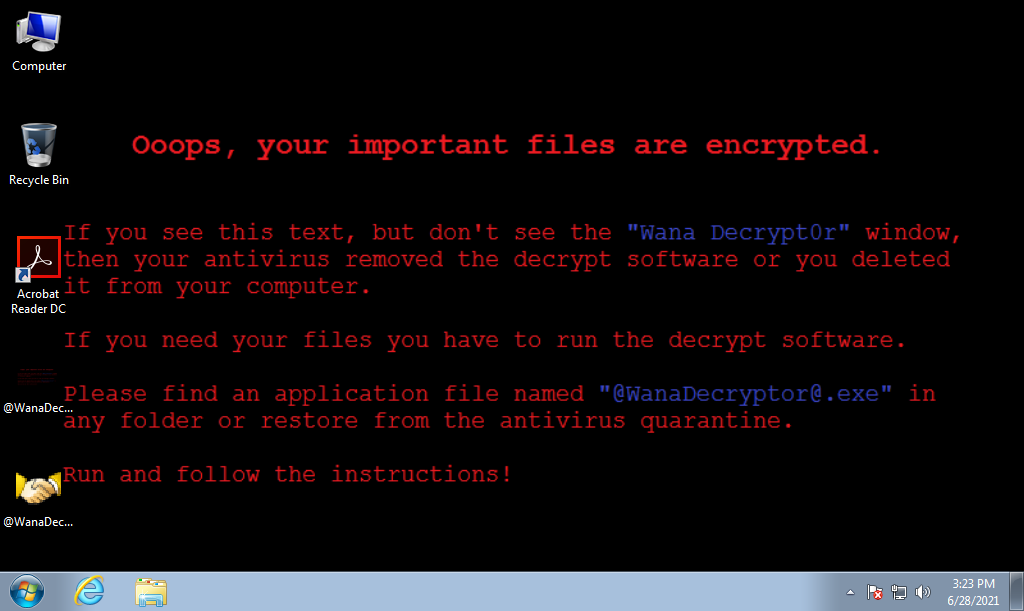

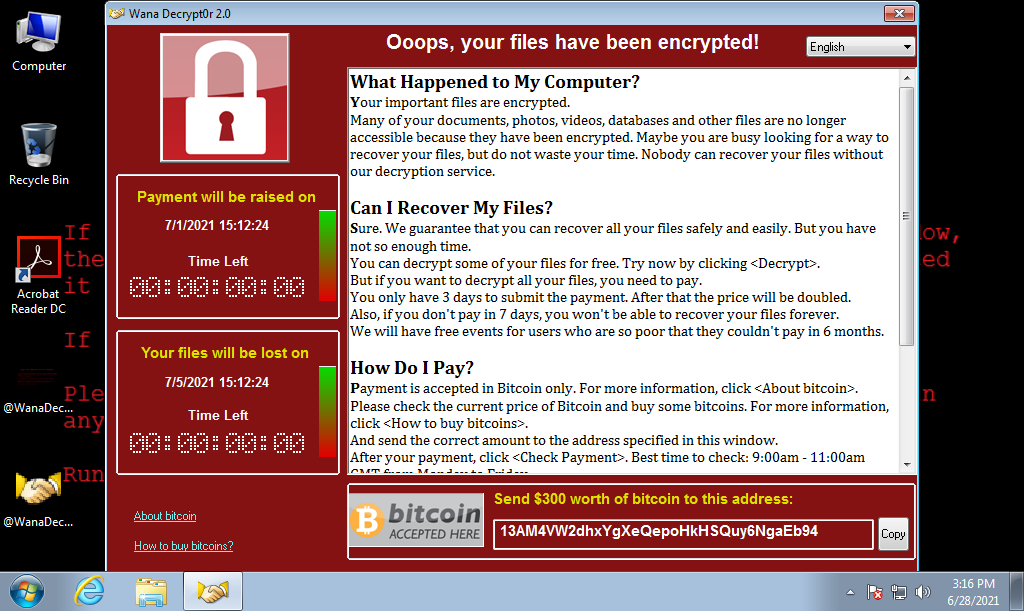

El analisis con la plataforma comprueba las sospechas que se tenian del software y de su objetivo